In [5]:
#import packages
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import fbeta_score
from sklearn.model_selection import ParameterGrid
import time
from  sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import shap
from sklearn.inspection import permutation_importance

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

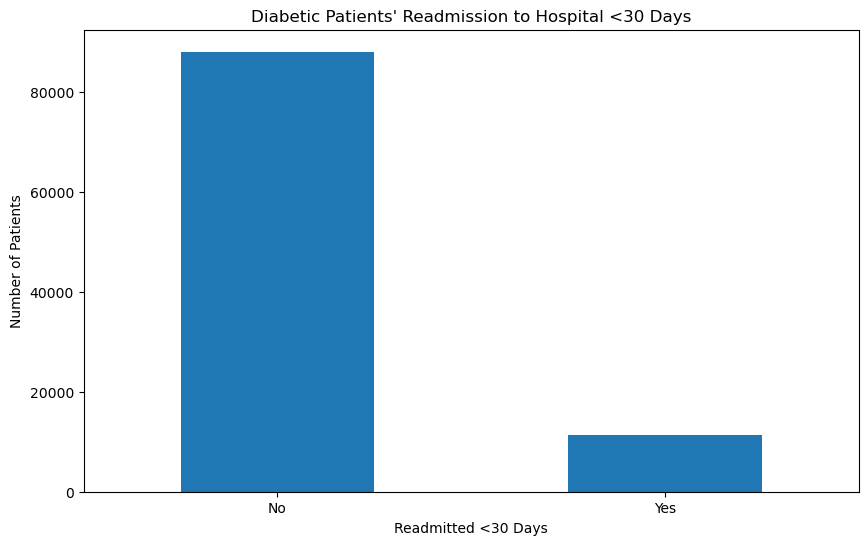

In [6]:
#read data
df = pd.read_csv("/Users/hudasaeed/Downloads/diabetic_data.csv",na_values = ["?","Unknown/Invalid","PhysicianNotFound"])

#explore
print(df.head())
print(df.shape) #101,766 rows, 50 columns
print(df.dtypes)

#filter data
df = df[~df['discharge_disposition_id'].isin([11,13,14,19,20,21])] #remove patients who passed/in hospice since cannot be readmitted
print(df.shape) #99,343 rows, 51 columns

#drop unknown gender because only 3 rows so when data is split sometimes an unknown gender point would land in training set and sometimes it wouldn't, leading to a different number of features across the random states since one model would have cat_gender_nan and the others wouldn't. I decided to remove these rows because of this and also because since there are only 3 I don't believe any strong relationship could be construed between unknown gender and my target
indices_to_drop = df[df['gender'].isna()].index
df.drop(indices_to_drop, inplace=True)
print(df[df['gender'].isna()])

#create + explore target
df['Y'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
print(df['Y'].value_counts())

plt.figure(figsize=(10,6))
pd.value_counts(df['Y']).plot.bar()
ax = plt.gca() #get axis
ax.set_xticklabels(['No','Yes'])
plt.xticks(rotation=0)  
plt.xlabel('Readmitted <30 Days')
plt.ylabel('Number of Patients')
plt.title('Diabetic Patients\' Readmission to Hospital <30 Days')
plt.savefig('/Users/hudasaeed/Desktop/DATA1030-Fall2023/target.png', dpi=300)
plt.show() #imbalanced data


In [7]:
#explore features

#patients
patient = df['patient_nbr'].value_counts()
print(patient[patient>1]) #16,341 patients repeat - group structure

#race
print(df['race'].value_counts())

#gender
print(df['gender'].value_counts())

#age
print(df['age'].value_counts())

#weight
print(df['weight'].value_counts())

#admission
df['admission_type_id'] = df['admission_type_id'].replace([5,6], 'NA') #from variable def
print(df['admission_type_id'].value_counts())

#discharge
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace([18,26], 'NA') #from variable def
print(df['discharge_disposition_id'].value_counts())

#admission source
df['admission_source_id'] = df['admission_source_id'].replace([9,15,17,21], 'NA') #from variable def
print(df['admission_source_id'].value_counts())

#time 
print(df['time_in_hospital'].value_counts()) #just to see all values
print(df['time_in_hospital'].describe())

#payer_code 
print(df['payer_code'].value_counts())

#medical_specialty 
pd.set_option('display.max_rows', 200)
df['medical_specialty'] = df['medical_specialty'].fillna('NA')
print(df['medical_specialty'].value_counts())

#labs 
print(df['num_lab_procedures'].describe())

#non lab procedures 
print(df['num_procedures'].describe())

#med 
print(df['num_medications'].describe())

#Number of outpatient visits of the patient in the year preceding 
print(df['number_outpatient'].describe())

#Number of emergency visits of the patient in the year preceding  
print(df['number_emergency'].describe())

#ICD 9 code
print(df['diag_1'].value_counts())
print(df['diag_2'].value_counts())
print(df['diag_3'].value_counts())

#diagnoses 
print(df['number_diagnoses'].describe())

#glucose
df['max_glu_serum'] = df['max_glu_serum'].fillna('No test') #from variable def
print(df['max_glu_serum'].value_counts())

#A1C
df['A1Cresult'] = df['A1Cresult'].fillna('No test') #from variable def
print(df['A1Cresult'].value_counts())

#metformin
print(df['metformin'].value_counts())

#repaglinide
print(df['repaglinide'].value_counts())

#nateglinide
print(df['nateglinide'].value_counts())

#chlorpropamide
print(df['chlorpropamide'].value_counts())

#glimepiride
print(df['glimepiride'].value_counts())

#acetohexamide
print(df['acetohexamide'].value_counts()) #rare

#glipizide
print(df['glipizide'].value_counts())

#glyburide
print(df['glyburide'].value_counts())

#tolbutamide
print(df['tolbutamide'].value_counts()) #rare

#pioglitazone
print(df['pioglitazone'].value_counts()) 

#rosiglitazone
print(df['rosiglitazone'].value_counts()) 

#acarbose
print(df['acarbose'].value_counts())

#miglitol
print(df['miglitol'].value_counts())

#troglitazone
print(df['troglitazone'].value_counts()) #rare - pulled in 2000 bc associated w liver failure

#tolazamide
print(df['tolazamide'].value_counts()) 

#examide
print(df['examide'].value_counts()) #no one takes this

#citoglipton
print(df['citoglipton'].value_counts()) #no one takes this

#insulin
print(df['insulin'].value_counts()) #most use

#glyburide-metformin
print(df['glyburide-metformin'].value_counts()) 

#glipizide-metformin
print(df['glipizide-metformin'].value_counts()) 

#glimepiride-pioglitazone
print(df['glimepiride-pioglitazone'].value_counts()) #rare

#metformin-rosiglitazone
print(df['metformin-rosiglitazone'].value_counts()) #rare

#metformin-pioglitazone
print(df['metformin-pioglitazone'].value_counts()) #rare

#change in diabetes med
print(df['change'].value_counts()) #about 50-50

#new diabetes med
print(df['diabetesMed'].value_counts()) 

#missing data
miss_ft = df.isnull().sum(axis=0)/df.shape[0]
imp_ft = miss_ft[miss_ft > 0]
print(imp_ft) #% of missing points for each feature with missing values 

#% of missing points for each feature with missing values for cleaned variables 
print(((df['admission_type_id'] == 'NA').sum())/df.shape[0])
print(((df['admission_source_id'] == 'NA').sum())/df.shape[0])
print(((df['discharge_disposition_id'] == 'NA').sum())/df.shape[0])
print(((df['medical_specialty'] == 'NA').sum())/df.shape[0])

#so they count in df.isnull()
df['admission_type_id'] = df['admission_type_id'].replace('NA', None)
df['admission_source_id'] = df['admission_source_id'].replace('NA', None)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace('NA', None)
df['medical_specialty'] = df['medical_specialty'].replace('NA', None)

miss_rows = df.isnull().sum(axis=1)
imp_rows = miss_rows[miss_rows>0]
print(len(imp_rows)/df.shape[0]) #% of rows with missing values - 99%

#convert back to NA for ease of use
df['admission_type_id'].fillna('NA', inplace=True)
df['admission_source_id'].fillna('NA', inplace=True)
df['discharge_disposition_id'].fillna('NA', inplace=True)
df['medical_specialty'].fillna('NA', inplace=True)

patient_nbr
88785891    40
43140906    28
23199021    23
88227540    23
1660293     23
            ..
73392147     2
24995241     2
79460595     2
62324739     2
85185999     2
Name: count, Length: 16341, dtype: int64
race
Caucasian          74220
AfricanAmerican    18772
Hispanic            2017
Other               1471
Asian                628
Name: count, dtype: int64
gender
Female    53454
Male      45886
Name: count, dtype: int64
age
[70-80)     25329
[60-70)     22058
[50-60)     17060
[80-90)     16434
[40-50)      9607
[30-40)      3764
[90-100)     2589
[20-30)      1649
[10-20)       690
[0-10)        160
Name: count, dtype: int64
weight
[75-100)     1312
[50-75)       867
[100-125)     617
[125-150)     143
[25-50)        90
[0-25)         48
[150-175)      34
[175-200)      11
>200            3
Name: count, dtype: int64
admission_type_id
1     52369
3     18667
2     18132
NA     9824
8       320
7        18
4        10
Name: count, dtype: int64
discharge_disposition_id
1  

Y                    0     1
race                        
AfricanAmerican  16623  2149
Asian              563    65
Caucasian        65664  8556
Hispanic          1805   212
Other             1327   144


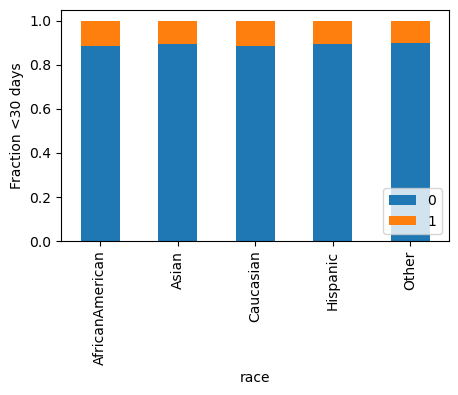

gender  Female   Male
Y                    
0        47326  40700
1         6128   5186


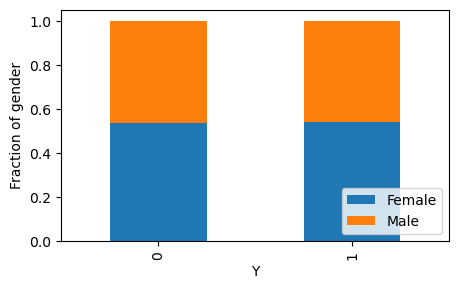

Y             0     1
age                  
[0-10)      157     3
[10-20)     650    40
[20-30)    1413   236
[30-40)    3340   424
[40-50)    8583  1024
[50-60)   15393  1667
[60-70)   19565  2493
[70-80)   22275  3054
[80-90)   14369  2065
[90-100)   2281   308


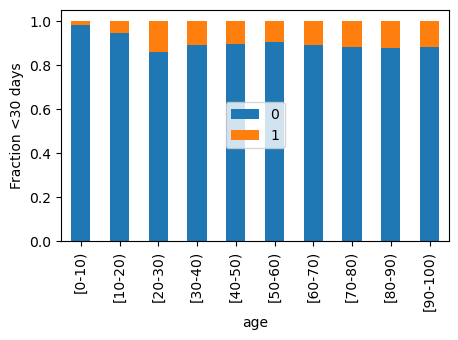

admission_type_id        1        2        3    4     7      8      NA
Y                                                                     
0                  46175.0  16074.0  16709.0  9.0  18.0  293.0  8748.0
1                   6194.0   2058.0   1958.0  1.0   NaN   27.0  1076.0


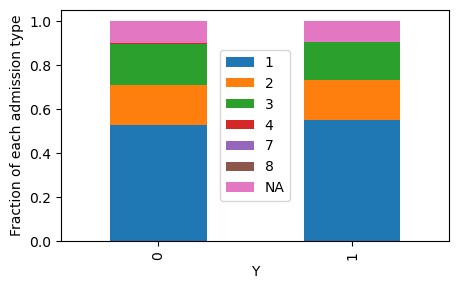

Y                               0       1
discharge_disposition_id                 
1                         54630.0  5602.0
2                          1786.0   342.0
3                         11908.0  2046.0
4                           711.0   104.0
5                           937.0   247.0
6                         11264.0  1638.0
7                           533.0    90.0
8                            93.0    15.0
9                            12.0     9.0
10                            6.0     NaN
12                            1.0     2.0
15                           35.0    28.0
16                           11.0     NaN
17                           14.0     NaN
22                         1440.0   552.0
23                          382.0    30.0
24                           41.0     7.0
25                          897.0    92.0
27                            5.0     NaN
28                           88.0    51.0
NA                         3232.0   459.0


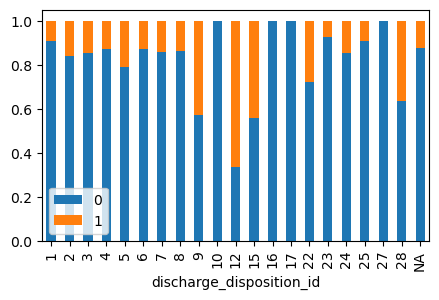

Y                          0       1
admission_source_id                 
1                    26047.0  3120.0
2                      970.0   111.0
3                      156.0    29.0
4                     2809.0   309.0
5                      706.0   100.0
6                     2027.0   212.0
7                    49158.0  6690.0
8                       13.0     2.0
10                       8.0     NaN
11                       2.0     NaN
13                       1.0     NaN
14                       2.0     NaN
20                     137.0    22.0
22                      10.0     2.0
25                       2.0     NaN
NA                    5978.0   717.0


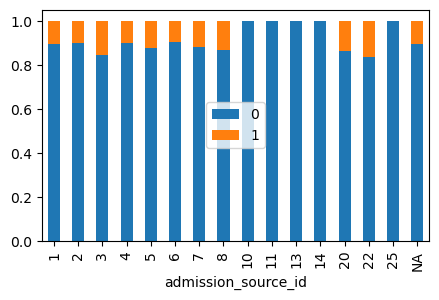

Y              0     1
A1Cresult             
>7          3392   383
>8          7328   809
No test    72865  9641
Norm        4441   481


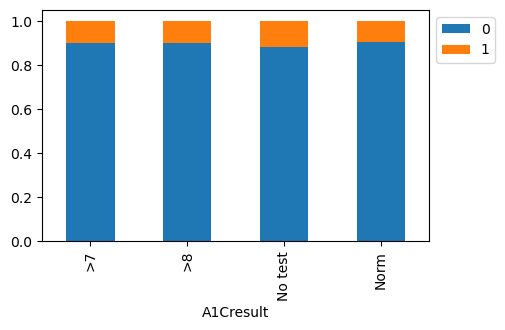

insulin   Down     No  Steady    Up
Y                                  
0        10215  41640   26649  9522
1         1693   4736    3420  1465


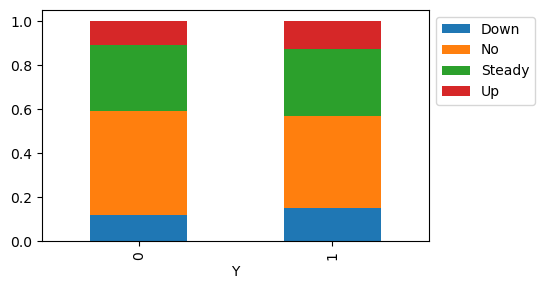

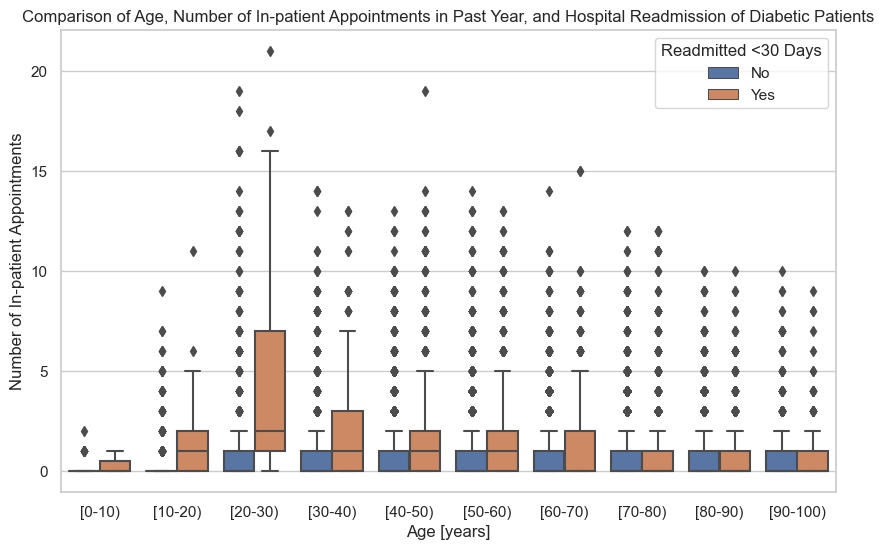

Y                           0     1
race            gender             
AfricanAmerican Female  10168  1295
                Male     6455   854
Asian           Female    292    24
                Male      271    41
Caucasian       Female  34196  4541
                Male    31468  4015
Hispanic        Female    986   100
                Male      819   112
Other           Female    657    77
                Male      670    67


<Figure size 1000x500 with 0 Axes>

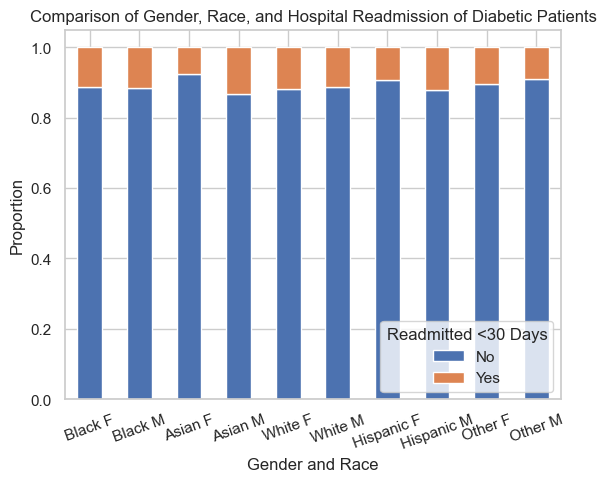

In [8]:
#explore target with other features

count_matrix = df.groupby(['race', 'Y']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(5,3))
plt.ylabel('Fraction <30 days')
plt.legend(loc=4)
plt.show()

count_matrix = df.groupby(['Y', 'gender']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(5,3))
plt.ylabel('Fraction of gender')
plt.legend(loc=4)
plt.show()

count_matrix = df.groupby(['age', 'Y']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(5,3))
plt.ylabel('Fraction <30 days')
plt.legend(loc=10)
plt.show()

count_matrix = df.groupby(['Y', 'admission_type_id']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(5,3))
plt.ylabel('Fraction of each admission type')
plt.legend(loc=10)
plt.show()

count_matrix = df.groupby(['discharge_disposition_id', 'Y']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(5,3))
plt.legend(loc=3)
plt.show()

count_matrix = df.groupby(['admission_source_id', 'Y']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(5,3))
plt.legend(loc=10)
plt.show()

count_matrix = df.groupby(['A1Cresult', 'Y']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(5,3))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

count_matrix = df.groupby(['Y', 'insulin']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(5,3))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#Data visualization 1
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='age', y='number_inpatient', hue='Y', data=df)
plt.title('Comparison of Age, Number of In-patient Appointments in Past Year, and Hospital Readmission of Diabetic Patients')
plt.xlabel('Age [years]')
plt.ylabel('Number of In-patient Appointments')
legend = plt.legend(title='Readmitted <30 Days', loc='upper right')
legend.get_texts()[0].set_text('No')
legend.get_texts()[1].set_text('Yes')
plt.savefig('/Users/hudasaeed/Desktop/DATA1030-Fall2023/age.png', dpi=300)
plt.show()

#Data visualization 2
pivot_table = df.pivot_table(index=['race', 'gender'], columns='Y', aggfunc='size', fill_value=0)
print(pivot_table)
pivot_table = pivot_table.div(pivot_table.sum(axis=1), axis=0)
plt.figure(figsize=(10, 5))
pivot_table.plot(kind='bar', stacked=True)
plt.title('Comparison of Gender, Race, and Hospital Readmission of Diabetic Patients')
plt.xlabel('Gender and Race')
plt.ylabel('Proportion')
labels = ['Black F','Black M','Asian F','Asian M','White F','White M','Hispanic F','Hispanic M',\
           'Other F','Other M']
# Customize the legend
legend = plt.legend(title='Readmitted <30 Days', loc='lower right')
legend.get_texts()[0].set_text('No')
legend.get_texts()[1].set_text('Yes')
plt.xticks(range(10), labels, rotation=20)
plt.savefig('/Users/hudasaeed/Desktop/DATA1030-Fall2023/race.png', dpi=300)
plt.show()


In [9]:
#fix data types before binning
for column in df.columns:
    data_types = df[column].apply(type).unique()
    if len(data_types) > 1:
        print(f"Column '{column}' has mixed data types: {data_types}")
df['race'] = df['race'].astype(str)
df['gender'] = df['gender'].astype(str)
df['weight'] = df['weight'].astype(str)
df['admission_type_id'] = df['admission_type_id'].astype(str)
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype(str)
df['admission_source_id'] = df['admission_source_id'].astype(str)
df['payer_code'] = df['payer_code'].astype(str)
df['medical_specialty'] = df['medical_specialty'].astype(str)
df['diag_1'] = df['diag_1'].astype(str)
df['diag_2'] = df['diag_2'].astype(str)
df['diag_3'] = df['diag_3'].astype(str)

for column in df.columns:
    data_types = df[column].apply(type).unique()
    if len(data_types) > 1:
        print(f"Column '{column}' has mixed data types: {data_types}")

Column 'race' has mixed data types: [<class 'str'> <class 'float'>]
Column 'weight' has mixed data types: [<class 'float'> <class 'str'>]
Column 'admission_type_id' has mixed data types: [<class 'str'> <class 'int'>]
Column 'discharge_disposition_id' has mixed data types: [<class 'int'> <class 'str'>]
Column 'admission_source_id' has mixed data types: [<class 'int'> <class 'str'>]
Column 'payer_code' has mixed data types: [<class 'float'> <class 'str'>]
Column 'diag_1' has mixed data types: [<class 'str'> <class 'float'>]
Column 'diag_2' has mixed data types: [<class 'float'> <class 'str'>]
Column 'diag_3' has mixed data types: [<class 'float'> <class 'str'>]


In [10]:
#bin sparse variables

df['new_weight'] = np.where(df['weight'].isin(['[150-175)', '[175-200)', '>200']), '>=150', df['weight'])
print(df['new_weight'].value_counts())

df['new_pay'] = np.where(df['payer_code'].isin(['FR']), 'OT', df['payer_code'])
print(df['new_pay'].value_counts())

df['new_admit'] = np.where(df['admission_type_id'].isin(['4','7','8']), 'Other', df['admission_type_id'])
print(df['new_admit'].value_counts())

df['new_admit_source'] = np.where(df['admission_source_id'].isin(['8','22','10','14','11','25','13']), 'Other', df['admission_source_id'])
print(df['new_admit_source'].value_counts())

df['new_discharge'] = np.where(df['discharge_disposition_id'].isin(['9','17','16','10','27','12']), 'Other', df['discharge_disposition_id'])
print(df['new_discharge'].value_counts())

#Used https://en.wikipedia.org/wiki/List_of_ICD-9_codes to bin
def map_icd9_to_category(icd9):
    if str(icd9)[0].isdigit() == False:
        return 'Factors influencing Health Status and Contact with Health Services/External Causes of Injury and Poisoning/Morphology of Neoplasms'
    else:
        code_int = int(str(icd9)[:3])
        if 1 <= code_int <= 139:
            return 'Infectious/Parasitic'
        elif 140 <= code_int <= 239:
            return 'Neoplasms'
        elif 240 <= code_int <= 279:
            return 'Endocrine/Nutritional/Metabolic/Immunity'
        elif 280 <= code_int <= 289:
            return 'Blood'
        elif 290 <= code_int <= 319:
            return 'Mental'
        elif 320 <= code_int <= 389:
            return 'Nervous System/Sense Organs'
        elif 390 <= code_int <= 459:
            return 'Circulatory'
        elif 460 <= code_int <= 519:
            return 'Respiratory'
        elif 520 <= code_int <= 579:
            return 'Digestive'
        elif 580 <= code_int <= 629:
            return 'Genitourinary'
        elif 630 <= code_int <= 679:
            return 'Pregnancy/Childbirth/Puerperium'
        elif 680 <= code_int <= 709:
            return 'Skin'
        elif 710 <= code_int <= 739:
            return 'Musculoskeletal'
        elif 740 <= code_int <= 759:
            return 'Congenital Anomalies'
        elif 760 <= code_int <= 779:
            return 'Perinatal'
        elif 780 <= code_int <= 799:
            return 'Symptoms/Ill-defined Conditions'
        elif 800 <= code_int <= 999:
            return 'Injury/Poisoning'
        else:
            return 'Other-dig'

df['new_diag1'] = df['diag_1'].apply(lambda x: map_icd9_to_category(x))
df['new_diag2'] = df['diag_2'].apply(lambda x: map_icd9_to_category(x))
df['new_diag3'] = df['diag_3'].apply(lambda x: map_icd9_to_category(x))
print(df['new_diag1'].value_counts())
print(df['new_diag2'].value_counts())
print(df['new_diag3'].value_counts())

def map_spec_to_category(spec):
    if spec=='NA':
        return 'missing'
    spec = str(spec)

    if 'Surg' in spec:
        return 'Surgery'
    elif 'Pediatric' in spec:
        return 'Pediatric'
    elif 'Emerg' in spec:
        return 'Emergency/Trauma'
    elif 'Family' in spec:
        return 'Family/GeneralPractice '
    elif 'Cardio' in spec:
        return 'Cardiology'
    elif 'Internal' in spec or 'Pulmonology' in spec:
        return 'Internal'
    elif 'Nephrology' in spec:
        return 'Nephrology'
    elif 'Orthopedics' in spec:
        return 'Orthopedics'
    elif 'Radio' in spec:
        return 'Radiology'
    elif 'Psychiatry' in spec:
        return 'Psychiatry'
    elif 'Urology' in spec:
        return 'Urology'
    elif 'Gyn' in spec or 'Obstetrics' in spec:
        return 'OBGYN'
    elif 'Gastroenterology' in spec:
        return 'Gastroenterology'
    elif 'PhysicalMedicineandRehabilitation' in spec:
        return 'PhysicalMedicineandRehabilitation'
    elif 'Oncology' in spec or 'Hematology' in spec:
        return 'Hematology/Oncology'
    elif 'Neuro' in spec:
        return 'Neurology'
    elif 'Otolaryngology' in spec:
        return 'Otolaryngology'
    elif 'Endocrinology' in spec:
        return 'Endocrinology'
    elif 'Psychology' in spec:
        return 'Psychology'
    elif 'Podiatry' in spec:
        return 'Podiatry'
    elif 'Hospitalist' in spec:
        return 'Hospitalist'
    elif 'Pathology' in spec or 'InfectiousDiseases' in spec:
        return 'Pathology'
    else: 
        return 'Other'

df['new_spec'] = df['medical_specialty'].apply(lambda x: map_spec_to_category(x))
print(df['new_spec'].value_counts())

new_weight
nan          96215
[75-100)      1312
[50-75)        867
[100-125)      617
[125-150)      143
[25-50)         90
[0-25)          48
>=150           48
Name: count, dtype: int64
new_pay
nan    39397
MC     31333
HM      6195
SP      4941
BC      4601
MD      3473
CP      2464
UN      2411
CM      1880
OG      1011
PO       585
DM       545
CH       142
WC       135
OT        93
MP        79
SI        55
Name: count, dtype: int64
new_admit
1        52369
3        18667
2        18132
NA        9824
Other      348
Name: count, dtype: int64
new_admit_source
7        55848
1        29167
NA        6695
4         3118
6         2239
2         1081
5          806
3          185
20         159
Other       42
Name: count, dtype: int64
new_discharge
1        60232
3        13954
6        12902
NA        3691
2         2128
22        1992
5         1184
25         989
4          815
7          623
23         412
28         139
8          108
15          63
Other       60
24          4

In [11]:
#split and preprocessing

y = df['Y']
#drop responses, IDs, troglitazone since pulled in 2000, and sparse variables
X = df.drop(columns=['Y','encounter_id','patient_nbr','readmitted','diag_1','diag_2','diag_3','troglitazone','medical_specialty','admission_type_id','admission_source_id','weight','discharge_disposition_id','payer_code'])
print(X.columns)
patient = df['patient_nbr']

#extract sample to use since it takes too long to use entire dataset
start_time = time.time()
cv = StratifiedGroupKFold(n_splits=7, shuffle=True, random_state=2)
rest_i, sample_i = next(cv.split(X, y, groups=patient)) #next() ensures you get the first split
X_sample, y_sample, groups_sample = X.iloc[sample_i], y.iloc[sample_i], patient.iloc[sample_i]
end_time = time.time()

print('cv1time',end_time - start_time)

ordinal_ftrs = ['age','new_weight','max_glu_serum','A1Cresult', 'metformin', \
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', \
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', \
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',  \
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
       'glimepiride-pioglitazone', 'metformin-rosiglitazone', \
       'metformin-pioglitazone'] 

ordinal_cats = [['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)'],\
                ['nan','[0-25)','[25-50)','[50-75)','[75-100)','[100-125)','[125-150)','>=150'],\
                ['No test','Norm','>200','>300'],
                 ['No test','Norm','>7','>8'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],\
               ['No','Down','Steady','Up'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],\
               ['No','Down','Steady','Up'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],\
                ['No','Down','Steady','Up'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],['No','Down','Steady','Up'],\
                ['No','Down','Steady','Up'],['No','Down','Steady','Up']
               ]
cat_ftrs = ['race','gender','new_admit_source','new_discharge',\
              'new_admit','new_pay','change','diabetesMed','new_spec','new_diag1','new_diag2','new_diag3']
num_ftrs = ['time_in_hospital','num_lab_procedures','num_procedures',\
            'num_medications','number_outpatient','number_emergency','number_inpatient',\
            'number_diagnoses']

# one-hot encoder
# We need to replace the NaN with a string first!
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# ordinal encoder
# We need to replace the NaN with a string first!
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

#f1 metric because imbalanced and interested in IDing all true positives and minimizing false positives due to cost
#baseline score
fbeta_score(y_sample,np.ones(len(y_sample)),beta=1)

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'new_weight',
       'new_pay', 'new_admit', 'new_admit_source', 'new_discharge',
       'new_diag1', 'new_diag2', 'new_diag3', 'new_spec'],
      dtype='object')
cv1time 19.552234888076782


0.19757053795231058

In [68]:
clean = df.drop(columns=['encounter_id','patient_nbr','readmitted','diag_1','diag_2','diag_3','troglitazone','medical_specialty','admission_type_id','admission_source_id','weight','discharge_disposition_id','payer_code'])
clean.to_csv('/Users/hudasaeed/Desktop/DATA1030-Fall2023/clean_data.csv')

In [12]:
#ML pipeline 

def f1_StratGroup(X_sample,y_sample,groups_sample,classifier,preprocessor,param_grid,XGBoost=True):
    
    random_states = [1, 10, 20, 30, 50]

    X_test_sets = []

    train_scores = []
    val_scores = []
    test_scores = []

    pred = []
    true = []

    best_models = []
    
    for i in random_states: 

        #split into other and test
        start_time = time.time()
        cv2 = StratifiedGroupKFold(n_splits=6, shuffle=True, random_state=i)
        other_i, test_i = next(cv2.split(X_sample, y_sample, groups=groups_sample)) #next() ensures you get the first split
        X_other, y_other, groups_other = X_sample.iloc[other_i], y_sample.iloc[other_i], groups_sample.iloc[other_i]
        X_test, y_test, groups_test = X_sample.iloc[test_i], y_sample.iloc[test_i], groups_sample.iloc[test_i]
        end_time = time.time()
    
        print('cv2time',end_time - start_time)

        #split into train and validation
        start_time = time.time()
        cv3 = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=i)
        for train_i, val_i in (cv3.split(X_other, y_other, groups=groups_other)):
            X_val = X_other.iloc[val_i,]
            X_train = X_other.iloc[train_i,]
            y_val = y_other.iloc[val_i,]
            y_train = y_other.iloc[train_i,]
            groups_val = groups_other.iloc[val_i,]
            groups_train = groups_other.iloc[train_i,]
            print(np.unique(y_train, return_counts=True))
            print(np.unique(y_val, return_counts=True))
            print(np.unique(y_test, return_counts=True))
        end_time = time.time()
    
        print('cv3time',end_time - start_time)

        #preprocess
        start_time = time.time()
        X_train_prep = preprocessor.fit_transform(X_train)
        X_val_prep = preprocessor.transform(X_val)
        X_test_prep = preprocessor.transform(X_test)
        end_time = time.time()
        
        print('processtime',end_time - start_time)

        X_test_sets.append(pd.DataFrame(X_test_prep))
        
        print('Train shape', X_train_prep.shape, y_train.shape)
        print('Val shape', X_val_prep.shape, y_val.shape)
        print('Test shape', X_test_prep.shape, y_test.shape)

        print('clf',len(clf.get_feature_names_out()),clf.get_feature_names_out())

        #for XGC evaluation metric
        def xgb_f1(y, t, threshold=0.5):
            t = t.get_label()
            y_bin = (y > threshold).astype(int) 
            return 'f1',fbeta_score(t,y_bin,beta=1) 
            
        start_time = time.time()        
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            if XGBoost==True:
                 mod = XGBClassifier(**params,random_state = 42*i,n_jobs=-1)       
                 mod = mod.fit(X_train_prep,y_train,eval_metric=xgb_f1,eval_set=[(X_val_prep,y_val)],verbose=False,early_stopping_rounds=10)
            if XGBoost==False:
                mod = classifier(**params) 
                mod.fit(X_train_prep,y_train) 
            best_models.append(mod) 
            print(mod)
            
            y_train_pred = mod.predict(X_train_prep)
            train_scores.append(fbeta_score(y_train,y_train_pred,beta=1))
            
            y_val_pred = mod.predict(X_val_prep)
            val_scores.append(fbeta_score(y_val,y_val_pred,beta=1))

            true.append(y_test)
            y_test_pred = mod.predict(X_test_prep)
            pred.append(y_test_pred)
            test_scores.append(fbeta_score(y_test,y_test_pred,beta=1))
            print(test_scores[-1])
        end_time = time.time()
    
        print('paramtime',end_time - start_time)
         
    return X_test_sets, train_scores, val_scores, test_scores, best_models, pred, true 

In [240]:
#Logistic regression
param_grid = {"penalty": [None,'l1','l2'],
                  "random_state": [0],
                 "class_weight": [{0:.4,1:.6},{0:.3,1:.7},{0:.2,1:.8}],
                 "C": [1e-2, 1e-1, 1e0, 1e1, 1e2],
                 "solver": ['saga'],
                 "max_iter": [10000]}              
                 # "n_jobs": [-1]}
                 # "l1_ratio": [0, .25, .5, .75, 1]}
X_test_prep_log, train_scores_log, val_scores_log, test_scores_log, best_models_log, pred_log, true_log = f1_StratGroup(X_sample,y_sample,groups_sample,LogisticRegression,clf,param_grid,XGBoost=False)

cv2time 1.3812861442565918
(array([0, 1]), array([7824,  962]))
(array([0, 1]), array([2595,  323]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7807,  970]))
(array([0, 1]), array([2612,  315]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7830,  976]))
(array([0, 1]), array([2589,  309]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7796,  947]))
(array([0, 1]), array([2623,  338]))
(array([0, 1]), array([2066,  252]))
cv3time 0.7383449077606201
processtime 0.08046579360961914
Train shape (8743, 167) (8743,)
Val shape (2961, 167) (2961,)
Test shape (2318, 167) (2318,)
clf 167 ['num__time_in_hospital' 'num__num_lab_procedures' 'num__num_procedures'
 'num__num_medications' 'num__number_outpatient' 'num__number_emergency'
 'num__number_inpatient' 'num__number_diagnoses'
 'cat__race_AfricanAmerican' 'cat__race_Asian' 'cat__race_Caucasian'
 'cat__race_Hispanic' 'cat__race_Other' 'cat__race_nan'
 'cat__gender_Female' 'cat__gender_Male' 'cat__ne

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.11295681063122924
LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.007874015748031496
LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.06569343065693431


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.1818181818181818
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.05243445692883895
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.11221122112211221


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.23971377459749552
LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.1372549019607843
LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.2338308457711443


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.11295681063122924
LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.07272727272727272
LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.07142857142857141


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.1818181818181818
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.14102564102564102
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.15902140672782875


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.23971377459749552
LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.26150121065375304
LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.256198347107438
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000, penalty=None,
                   random_state=0, solver='saga')
0.11295681063122924
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000, penalty='l1',
                   random_state=0, solver='saga')
0.08304498269896193
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.10169491525423728
LogisticRegression(class_weight={0: 0.3, 1: 0.7}, max_iter=10000, penalty=None,
                   random_sta

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.11295681063122924
LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.11295681063122924
LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.11295681063122924


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.1818181818181818
LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.18435754189944134
LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.18333333333333338


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.23971377459749552
LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.24955436720142607
LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.2464285714285714


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.11295681063122924
LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.11295681063122924
LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.11295681063122924


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.1818181818181818
LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.18232044198895025
LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.18232044198895025


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.23971377459749552
LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.23971377459749552
LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.23971377459749552
paramtime 902.3725759983063
cv2time 1.456399917602539
(array([0, 1]), array([7827,  930]))
(array([0, 1]), array([2616,  387]))
(array([0, 1]), array([2042,  220]))
(array([0, 1]), array([7822,  987]))
(array([0, 1]), array([2621,  330]))
(array([0, 1]), array([2042,  220]))
(array([0, 1]), array([7909, 1031]))
(array([0, 1]), array([2534,  286]))
(array([0, 1]), array([2042,  220]))
(array([0, 1]), array([7771, 1003]))
(array([0, 1]), array([2672,  314]))
(array([0, 1]), array([2042,  220]))
cv3time 0.7521231174468994
processtime 

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.06451612903225805
LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.0
LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.008849557522123894


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.11111111111111113
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.017467248908296942
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.0816326530612245


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.1940928270042194
LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.07874015748031496
LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.10810810810810811


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.06451612903225805
LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.008695652173913044
LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.034334763948497854


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.11111111111111113
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.0784313725490196
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.09848484848484848


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.1940928270042194
LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.10888252148997137
LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.18137254901960784
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000, penalty=None,
                   random_state=0, solver='saga')
0.06451612903225805
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000, penalty='l1',
                   random_state=0, solver='saga')
0.04201680672268908
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.042194092827004225
LogisticRegression(class_weight={0: 0.3, 1: 0.7}, max_iter=10000, penalty=None,
                   random_s

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.06451612903225805
LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.057142857142857134
LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.056910569105691054


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.11111111111111113
LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.11228070175438595
LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.11149825783972124


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.1940928270042194
LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.20042643923240938
LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.19574468085106383


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.06451612903225805
LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.06477732793522267
LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.06477732793522267


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.11111111111111113
LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.11111111111111113
LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.11111111111111113


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.1940928270042194
LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.1940928270042194
LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.1940928270042194
paramtime 840.0381901264191
cv2time 1.458467960357666
(array([0, 1]), array([7819,  950]))
(array([0, 1]), array([2598,  341]))
(array([0, 1]), array([2068,  246]))
(array([0, 1]), array([7813,  959]))
(array([0, 1]), array([2604,  332]))
(array([0, 1]), array([2068,  246]))
(array([0, 1]), array([7803,  960]))
(array([0, 1]), array([2614,  331]))
(array([0, 1]), array([2068,  246]))
(array([0, 1]), array([7816, 1004]))
(array([0, 1]), array([2601,  287]))
(array([0, 1]), array([2068,  246]))
cv3time 0.7397961616516113
processtime 0.0

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.072992700729927
LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.01606425702811245
LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.0392156862745098


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.12804878048780488
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.0316205533596838
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.08208955223880597


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.26953125
LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.11387900355871888
LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.18232044198895028


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.072992700729927
LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.046511627906976744
LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.06896551724137931


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.12804878048780488
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.12142857142857143
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.0896551724137931


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.26953125
LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.20266666666666666
LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.23853211009174313
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000, penalty=None,
                   random_state=0, solver='saga')
0.072992700729927
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000, penalty='l1',
                   random_state=0, solver='saga')
0.06844106463878326
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.07518796992481203
LogisticRegression(class_weight={0: 0.3, 1: 0.7}, max_iter=10000, penalty=None,
                   random_state=0, sol

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.072992700729927
LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.07352941176470587
LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.07352941176470587


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.12804878048780488
LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.12539184952978055
LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.12422360248447205


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.26953125
LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.26614481409001955
LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.26274509803921564


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.072992700729927
LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.072992700729927
LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.072992700729927


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.12804878048780488
LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.12804878048780488
LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.12804878048780488


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.26953125
LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.26953125
LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.26953125
paramtime 972.1825668811798
cv2time 1.4552428722381592
(array([0, 1]), array([7912,  961]))
(array([0, 1]), array([2570,  343]))
(array([0, 1]), array([2003,  233]))
(array([0, 1]), array([7829,  945]))
(array([0, 1]), array([2653,  359]))
(array([0, 1]), array([2003,  233]))
(array([0, 1]), array([7822, 1006]))
(array([0, 1]), array([2660,  298]))
(array([0, 1]), array([2003,  233]))
(array([0, 1]), array([7883, 1000]))
(array([0, 1]), array([2599,  304]))
(array([0, 1]), array([2003,  233]))
cv3time 0.7488741874694824
processtime 0.10321712493896484
Train 

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.06451612903225806
LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.0
LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.0


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.09929078014184398
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.0
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.01646090534979424


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.18433179723502302
LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.015810276679841896
LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.0707395498392283


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.06451612903225806
LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.0
LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.008474576271186442


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.09929078014184398
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.023809523809523808
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.04687499999999999


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.18433179723502302
LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.0877742946708464
LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.12637362637362637
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000, penalty=None,
                   random_state=0, solver='saga')
0.06451612903225806
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000, penalty='l1',
                   random_state=0, solver='saga')
0.041493775933609964
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.040983606557377046
LogisticRegression(class_weight={0: 0.3, 1: 0.7}, max_iter=10000, penalty=None,
                   random_

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.06451612903225806
LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.06451612903225806
LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.06451612903225806


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.09929078014184398
LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.09964412811387902
LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.09964412811387902


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.18433179723502302
LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.1822429906542056
LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.1818181818181818


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.06451612903225806
LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.06451612903225806
LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.06451612903225806


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.09929078014184398
LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.09929078014184398
LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.09929078014184398


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.18433179723502302
LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.18013856812933024
LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.18013856812933024
paramtime 927.473121881485
cv2time 1.3968567848205566
(array([0, 1]), array([7795,  903]))
(array([0, 1]), array([2629,  351]))
(array([0, 1]), array([2061,  283]))
(array([0, 1]), array([7820,  937]))
(array([0, 1]), array([2604,  317]))
(array([0, 1]), array([2061,  283]))
(array([0, 1]), array([7820,  948]))
(array([0, 1]), array([2604,  306]))
(array([0, 1]), array([2061,  283]))
(array([0, 1]), array([7837,  974]))
(array([0, 1]), array([2587,  280]))
(array([0, 1]), array([2061,  283]))
cv3time 0.7663569450378418
processtime 

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.09523809523809523
LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.04123711340206186
LogisticRegression(C=0.01, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.05351170568561873


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.14285714285714285
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.04713804713804714
LogisticRegression(C=0.01, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.0761904761904762


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.25225225225225223
LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.11585365853658537
LogisticRegression(C=0.01, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.16831683168316827


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.09523809523809523
LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.06578947368421052
LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.059016393442622946


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.14285714285714285
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.1033434650455927
LogisticRegression(C=0.1, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.11976047904191617


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.25225225225225223
LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.20476190476190476
LogisticRegression(C=0.1, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.2042553191489362
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000, penalty=None,
                   random_state=0, solver='saga')
0.09523809523809523
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000, penalty='l1',
                   random_state=0, solver='saga')
0.07766990291262137
LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.090032154340836
LogisticRegression(class_weight={0: 0.3, 1: 0.7}, max_iter=10000, penalty=None,
                   random_stat

Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.09523809523809523
LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.0949367088607595
LogisticRegression(C=10.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.09523809523809523


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.14285714285714285
LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.1392757660167131
LogisticRegression(C=10.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.13812154696132597


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.25225225225225223
LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.25136612021857924
LogisticRegression(C=10.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.2563176895306859


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.09523809523809523
LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.09523809523809523
LogisticRegression(C=100.0, class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=0, solver='saga')
0.09523809523809523


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.14285714285714285
LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.13774104683195593
LogisticRegression(C=100.0, class_weight={0: 0.3, 1: 0.7}, max_iter=10000,
                   random_state=0, solver='saga')
0.13812154696132597


Setting penalty=None will ignore the C and l1_ratio parameters


LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty=None, random_state=0, solver='saga')
0.25225225225225223
LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   penalty='l1', random_state=0, solver='saga')
0.2527075812274368
LogisticRegression(C=100.0, class_weight={0: 0.2, 1: 0.8}, max_iter=10000,
                   random_state=0, solver='saga')
0.25225225225225223
paramtime 668.8153109550476


In [249]:
#save Logistic Regression 
file = open('/Users/hudasaeed/Desktop/DATA1030-Fall2023/log.pkl', 'wb')
pickle.dump((X_test_prep_log, train_scores_log, val_scores_log, test_scores_log, best_models_log, pred_log, true_log),file)
file.close()

In [13]:
#open Logistic Regression
file = open('/Users/hudasaeed/Desktop/DATA1030-Fall2023/log.pkl', 'rb')
X_test_prep_log1, train_scores_log1, val_scores_log1, test_scores_log1, best_models_log1, pred_log1, true_log1 = pickle.load(file)
file.close()

In [260]:
#XGC
print(y_sample.value_counts()) #to determine value for scale_pos_weight
param_grid = {"n_estimators": [10000],
                  # "random_state": [0],
                 "reg_alpha": [0,1e-2, 1e-1, 1e0, 1e1, 1e2],
                 # "reg_lambda": [0,1e-2, 1e-1, 1e0, 1e1, 1e2],
                 "max_depth": [1,3,10,30,100],
                 "colsample_bytree": [0.9],              
                 "subsample": [0.66],
                 "scale_pos_weight": [8.12],
             "learning_rate": [0.03],
             "missing": [np.nan]}
             # "eval_metric":['f1']}
X_test_sets_XGC, train_scores_XGC, val_scores_XGC, test_scores_XGC, best_models_XGC, pred_XGC, true_XGC = f1_StratGroup(X_sample,y_sample,groups_sample,XGBClassifier,clf,param_grid,XGBoost=True)


Y
0    12485
1     1537
Name: count, dtype: int64
cv2time 1.395871877670288
(array([0, 1]), array([7824,  962]))
(array([0, 1]), array([2595,  323]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7807,  970]))
(array([0, 1]), array([2612,  315]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7830,  976]))
(array([0, 1]), array([2589,  309]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7796,  947]))
(array([0, 1]), array([2623,  338]))
(array([0, 1]), array([2066,  252]))
cv3time 0.7408251762390137
processtime 0.09248161315917969
Train shape (8743, 167) (8743,)
Val shape (2961, 167) (2961,)
Test shape (2318, 167) (2318,)
clf 167 ['num__time_in_hospital' 'num__num_lab_procedures' 'num__num_procedures'
 'num__num_medications' 'num__number_outpatient' 'num__number_emergency'
 'num__number_inpatient' 'num__number_diagnoses'
 'cat__race_AfricanAmerican' 'cat__race_Asian' 'cat__race_Caucasian'
 'cat__race_Hispanic' 'cat__race_Other' 'cat__race_nan'


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.27645376549094375
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_met

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

0.27645376549094375
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.25386165211551376
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categor

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.2526455026455026
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metr

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.25949367088607594
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_met

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.25


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.22192866578599738


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.22857142857142854


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.23100936524453694
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.19209039548022597


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.08695652173913043


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.09150326797385622


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.16939890710382513


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.17923186344238975


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.20393120393120392


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.14985590778097982


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.1337579617834395


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.15662650602409636


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.20574162679425836


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.17923186344238975


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
0.20393120393120392
paramtime 18.040477991104126
cv2time 1.3663330078125
(array([0, 1]), array([7827,  930]))
(array([0, 1]), array([2616,  387]))
(array([0, 1]), array([2042,  220]))
(array([0, 1]), array([7822,  987]))
(array([0, 1]), array([2621,  3

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.20382165605095542
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.2172619047619048
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_met

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.2172619047619048
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_met

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.21709006928406463
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.20030349013657053


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.20408163265306126


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.20022753128555176


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.2033898305084746
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.08000000000000002


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.09122807017543859


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.10596026490066227


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.16574585635359115


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.17283950617283947


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.1669449081803005


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.09059233449477352


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.10094637223974763


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.11538461538461539


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.1362397820163488


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.17283950617283947


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=420, ...)
0.1669449081803005
paramtime 13.723355054855347
cv2time 1.3833918571472168
(array([0, 1]), array([7819,  950]))
(array([0, 1]), array([2598,  341]))
(array([0, 1]), array([2068,  246]))
(array([0, 1]), array([7813,  959]))
(array([0, 1]), array([2604,

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.21906693711967548
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.2360034453057709
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_met

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.2360034453057709
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_met

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.23341729638958858
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.1898148148148148


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.185614849187935


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.18539976825028967


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.19755826859045503


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.18106139438085325
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_m

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.07308970099667775


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.09584664536741212


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.13079019073569484


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.158974358974359


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.18427518427518427


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.22193877551020408


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.08888888888888889


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.1094224924012158


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.0875


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.18734177215189873


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.18427518427518427


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=840, ...)
0.22193877551020408
paramtime 19.583827018737793
cv2time 1.372107744216919
(array([0, 1]), array([7912,  961]))
(array([0, 1]), array([2570,  343]))
(array([0, 1]), array([2003,  233]))
(array([0, 1]), array([7829,  945]))
(array([0, 1]), array([2653,

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.1916038751345533
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.1916038751345533
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.23391812865497078
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_m

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.23440134907251262
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_m

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.23183925811437403
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_m

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.20218579234972678


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.20237010027347313


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.20024721878862795


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.21254801536491683


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.23259372609028306


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.1243781094527363


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.03676470588235294


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.12584269662921346


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.11309523809523808


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.2040816326530612


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.16831683168316833


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.1206030150753769


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.0390625


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.12584269662921346


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.12680115273775217


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.2040816326530612


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=1260, ...)
0.16831683168316833
paramtime 12.028398990631104
cv2time 1.364370346069336
(array([0, 1]), array([7795,  903]))
(array([0, 1]), array([2629,  351]))
(array([0, 1]), array([2061,  283]))
(array([0, 1]), array([7820,  937]))
(array([0, 1]), array([2604

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.25650557620817843
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_m

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility w

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.2640555906506633
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.2640555906506633
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.2629370629370629
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_me

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.19376391982182628


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.20135746606334845


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.2160919540229885


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.246520874751491


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.26586102719033233


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.07272727272727272


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.06289308176100629


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.0898876404494382


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.14868105515587532


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.22929936305732487


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.1818181818181818


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.061728395061728385


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.06832298136645962


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.0672782874617737


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.14657210401891252


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.22929936305732487


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=2100, ...)
0.1818181818181818
paramtime 22.56674814224243


In [261]:
#save XGC
file = open('/Users/hudasaeed/Desktop/DATA1030-Fall2023/xgb.pkl', 'wb')
pickle.dump((X_test_sets_XGC, train_scores_XGC, val_scores_XGC, test_scores_XGC, best_models_XGC, pred_XGC, true_XGC),file)
file.close()

In [14]:
#open XGC
file = open('/Users/hudasaeed/Desktop/DATA1030-Fall2023/xgb.pkl', 'rb')
X_test_sets_XGC, train_scores_XGC, val_scores_XGC, test_scores_XGC, best_models_XGC, pred_XGC, true_XGC = pickle.load(file)
file.close()

In [262]:
#SVC

param_grid = {'gamma': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
                'C': [1e-1, 1e0, 1e1],
             'random_state':[0],
             'class_weight':['balanced']}
X_test_sets_svc, train_scores_svc, val_scores_svc, test_scores_svc, best_models_svc, pred_svc, true_svc = f1_StratGroup(X_sample,y_sample,groups_sample,SVC,clf,param_grid,XGBoost=False)

cv2time 1.621730089187622
(array([0, 1]), array([7824,  962]))
(array([0, 1]), array([2595,  323]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7807,  970]))
(array([0, 1]), array([2612,  315]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7830,  976]))
(array([0, 1]), array([2589,  309]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7796,  947]))
(array([0, 1]), array([2623,  338]))
(array([0, 1]), array([2066,  252]))
cv3time 0.7381560802459717
processtime 0.0935060977935791
Train shape (8743, 167) (8743,)
Val shape (2961, 167) (2961,)
Test shape (2318, 167) (2318,)
clf 167 ['num__time_in_hospital' 'num__num_lab_procedures' 'num__num_procedures'
 'num__num_medications' 'num__number_outpatient' 'num__number_emergency'
 'num__number_inpatient' 'num__number_diagnoses'
 'cat__race_AfricanAmerican' 'cat__race_Asian' 'cat__race_Caucasian'
 'cat__race_Hispanic' 'cat__race_Other' 'cat__race_nan'
 'cat__gender_Female' 'cat__gender_Male' 'cat__new_

In [263]:
#save SVC
file = open('/Users/hudasaeed/Desktop/DATA1030-Fall2023/svc.pkl', 'wb')
pickle.dump((X_test_sets_svc, train_scores_svc, val_scores_svc, test_scores_svc, best_models_svc, pred_svc, pred_svc),file)
file.close()

In [15]:
#open SVC
file = open('/Users/hudasaeed/Desktop/DATA1030-Fall2023/svc.pkl', 'rb')
X_test_sets_svc, train_scores_svc, val_scores_svc, test_scores_svc, best_models_svc, pred_svc, true_svc = pickle.load(file)
file.close()

In [16]:
#RFC

param_grid = {
              'max_depth': [None,1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             'max_features': [None,0.25, 0.5,0.75,1.0],
             'random_state':[0],
             'class_weight':['balanced','balanced_subsample']}
X_test_sets_rf, train_scores_rf, val_scores_rf, test_scores_rf, best_models_rf, pred_rf, true_rf = f1_StratGroup(X_sample,y_sample,groups_sample,RandomForestClassifier,clf,param_grid,XGBoost=False)

cv2time 2.5984621047973633
(array([0, 1]), array([7824,  962]))
(array([0, 1]), array([2595,  323]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7807,  970]))
(array([0, 1]), array([2612,  315]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7830,  976]))
(array([0, 1]), array([2589,  309]))
(array([0, 1]), array([2066,  252]))
(array([0, 1]), array([7796,  947]))
(array([0, 1]), array([2623,  338]))
(array([0, 1]), array([2066,  252]))
cv3time 1.2720181941986084
processtime 0.13888978958129883
Train shape (8743, 167) (8743,)
Val shape (2961, 167) (2961,)
Test shape (2318, 167) (2318,)
clf 167 ['num__time_in_hospital' 'num__num_lab_procedures' 'num__num_procedures'
 'num__num_medications' 'num__number_outpatient' 'num__number_emergency'
 'num__number_inpatient' 'num__number_diagnoses'
 'cat__race_AfricanAmerican' 'cat__race_Asian' 'cat__race_Caucasian'
 'cat__race_Hispanic' 'cat__race_Other' 'cat__race_nan'
 'cat__gender_Female' 'cat__gender_Male' 'cat__ne

KeyboardInterrupt: 

In [265]:
#save RFC
file = open('/Users/hudasaeed/Desktop/DATA1030-Fall2023/rf.pkl', 'wb')
pickle.dump((X_test_sets_rf, train_scores_rf, val_scores_rf, test_scores_rf, best_models_rf, pred_rf, true_rf),file)
file.close()

In [17]:
#open RFC
file = open('/Users/hudasaeed/Desktop/DATA1030-Fall2023/rf.pkl', 'rb')
X_test_sets_rf, train_scores_rf, val_scores_rf, test_scores_rf, best_models_rf, pred_rf, true_rf = pickle.load(file)
file.close()

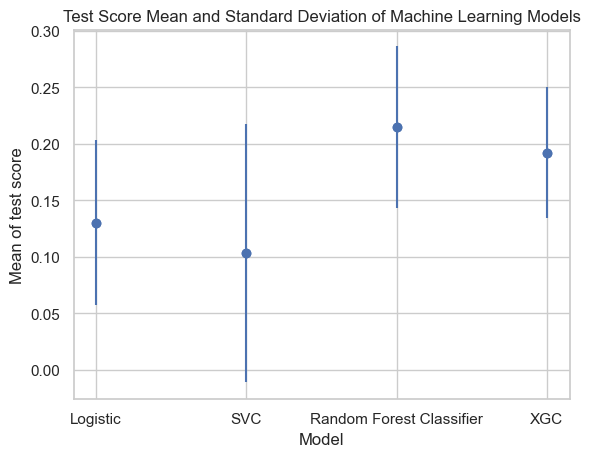

[0.13007522818531805, 0.10325630258926667, 0.21478370568432972, 0.19216984047090316]
[0.07305192535677746, 0.11447315758979518, 0.07149467054130958, 0.0578504150589727]


array([-0.92393608, -0.82389826,  0.24076155, -0.09335624])

In [18]:
#uncertainties
mean = [np.mean(test_scores_log1),np.mean(test_scores_svc),np.mean(test_scores_rf),np.mean(test_scores_XGC)]
std = [np.std(test_scores_log1),np.std(test_scores_svc),np.std(test_scores_rf),np.std(test_scores_XGC)]
plt.scatter(['Logistic','SVC','Random Forest Classifier','XGC'],mean)
plt.errorbar(['Logistic','SVC','Random Forest Classifier','XGC'],mean,yerr=std, fmt='o')
plt.xlabel('Model')
plt.ylabel('Mean of test score')
plt.title('Test Score Mean and Standard Deviation of Machine Learning Models')
plt.savefig('/Users/hudasaeed/Desktop/DATA1030-Fall2023/uncert.png', dpi=300)
plt.show()
print(mean)
print(std)
np.subtract(mean,fbeta_score(y_sample,np.ones(len(y_sample)),beta=1))/std #compare models to baseline

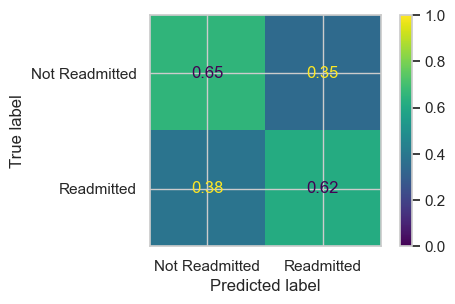

In [19]:
#cm of best model
best = best_models_rf[np.argmax(val_scores_rf)]
pred_best = pred_rf[np.argmax(val_scores_rf)]
true_best = true_rf[np.argmax(val_scores_rf)]

cm = confusion_matrix(true_best,pred_best,normalize='true')
disp = ConfusionMatrixDisplay(cm,display_labels=['Not Readmitted', 'Readmitted'])
fig, ax = plt.subplots(figsize=(5,3))
disp.plot(ax=ax)
disp.ax_.get_images()[0].set_clim(0, 1)
plt.savefig('/Users/hudasaeed/Desktop/DATA1030-Fall2023/cm.png', dpi=300)
plt.show()

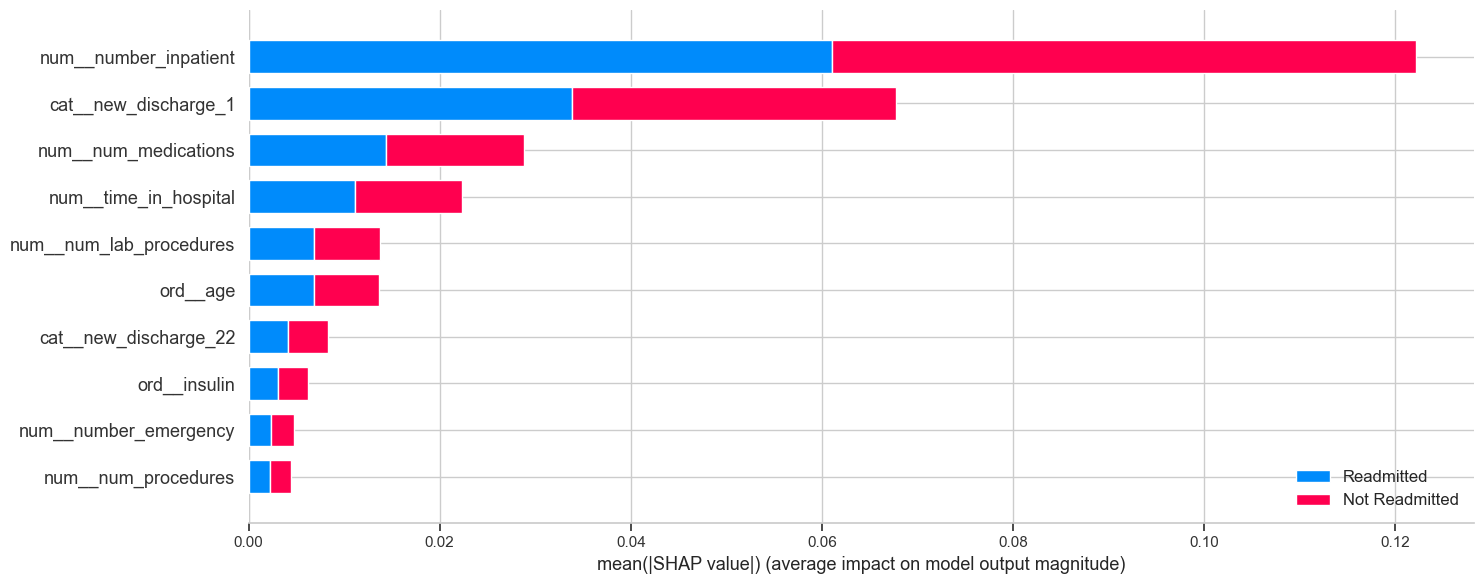

In [26]:
#global shap
shap.initjs() # required for visualizations 
names = clf.get_feature_names_out()
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(X_test_sets_rf[0])
shap.summary_plot(shap_values, X_test_sets_rf[0],feature_names = names,max_display=10,class_names=['Not Readmitted', 'Readmitted'],plot_size=[15,6],show=False)
plt.savefig('/Users/hudasaeed/Desktop/DATA1030-Fall2023/SHAP_global.png', dpi=300)
plt.show()


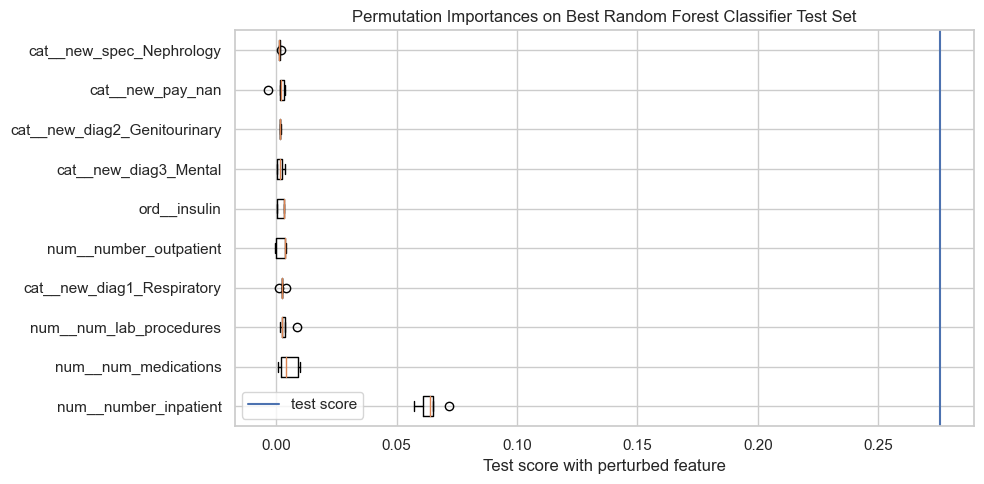

In [22]:
#permutation importance
perm_importance = permutation_importance(best, X_test_sets_rf[0], true_rf[np.argmax(val_scores_rf)], random_state=0,scoring='f1')

# Sort feature importances
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]

# Select the top 10 features
top = names[sorted_idx[:10]]
plt.figure(figsize=(10,5))
plt.boxplot(perm_importance.importances[sorted_idx[:10]].T,labels=top,vert=False)
plt.axvline(test_scores_rf[np.argmax(val_scores_rf)],label='test score')
plt.title("Permutation Importances on Best Random Forest Classifier Test Set")
plt.xlabel('Test score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/hudasaeed/Desktop/DATA1030-Fall2023/perm.png', dpi=300)
plt.show()

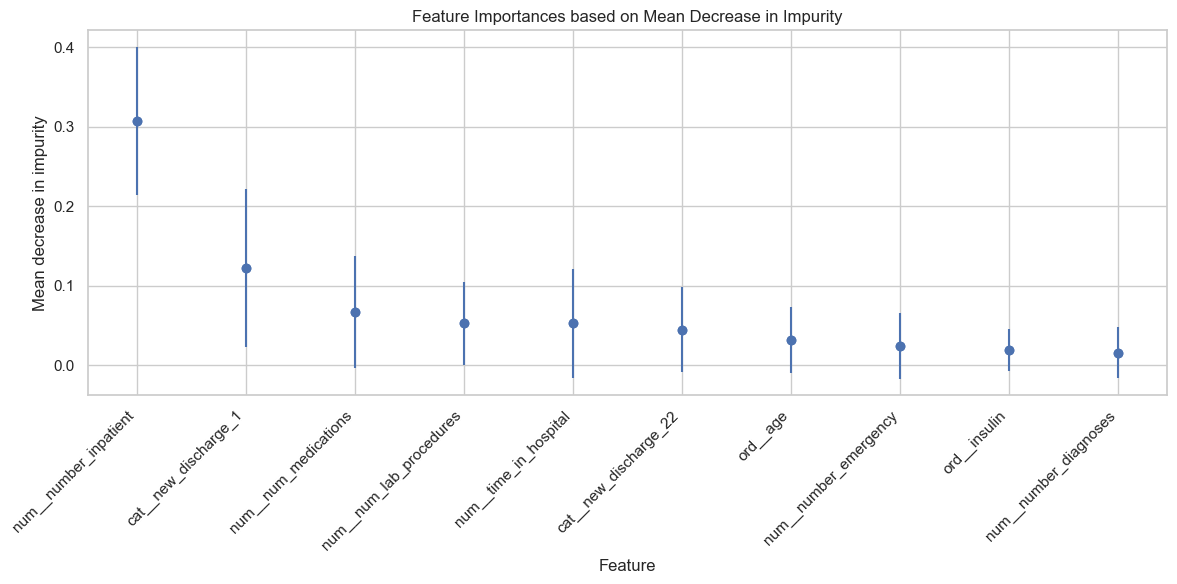

In [57]:
#mean decrease in impurity
importances = best.feature_importances_
std = np.std([tree.feature_importances_ for tree in best.estimators_], axis=0)

sorted_idx = np.argsort(importances)[::-1]

# Select the top 10 features
top = names[sorted_idx[:10]]
importances = importances[sorted_idx[:10]]
std = std[sorted_idx[:10]]

plt.figure(figsize=(12, 6))
plt.scatter(top,importances)
plt.errorbar(top,importances,yerr=std, fmt='o')
plt.title("Feature Importances based on Mean Decrease in Impurity")
plt.ylabel('Mean decrease in impurity')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')  # Adjust rotation and horizontal alignment
plt.tight_layout()  
plt.savefig('/Users/hudasaeed/Desktop/DATA1030-Fall2023/mean_decrease_impurity.png', dpi=300)
plt.show()

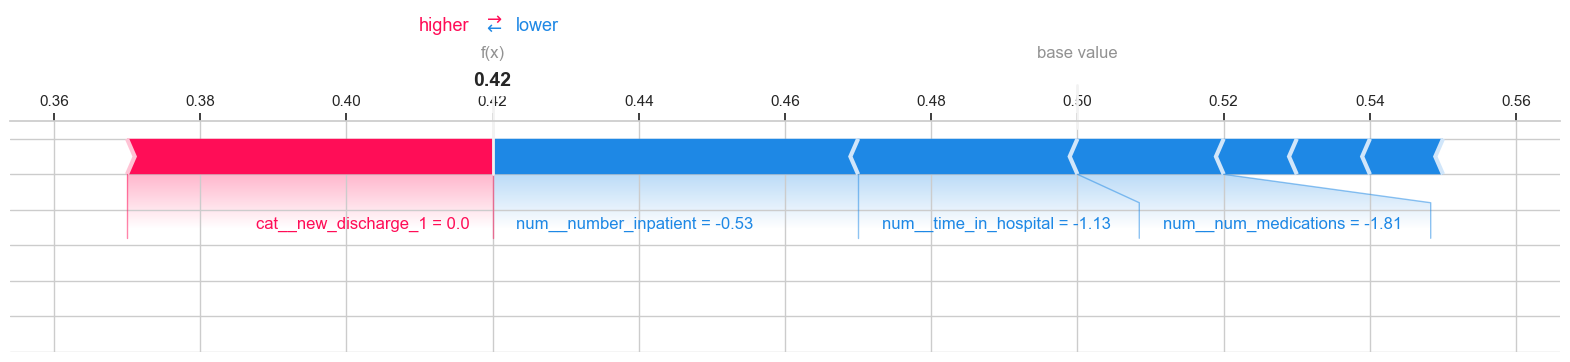

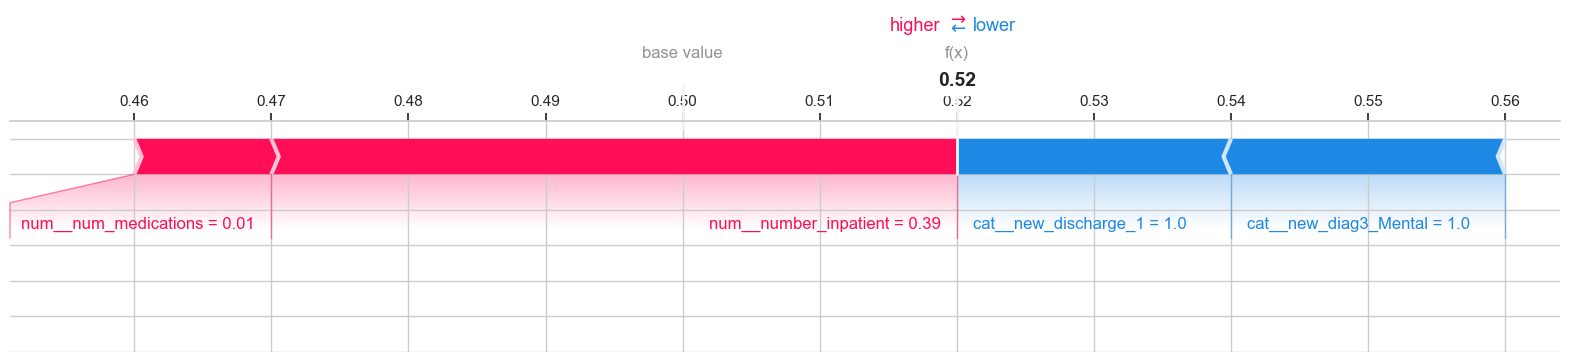

In [66]:
index = [0,1981] # the index of the point to explain

for i in index:
    shap.force_plot(np.around(explainer.expected_value[1], decimals=2), np.around(shap_values[1][i,:], \
                    decimals = 2), features = np.around(X_test_sets_rf[0].iloc[i,:], decimals=2),feature_names = names,\
                    matplotlib=True,show=False)
    # plt.tight_layout(pad=0)
    # plt.savefig(f'/Users/hudasaeed/Desktop/DATA1030-Fall2023/SHAP_index{i}.png', dpi=300)
    plt.show()
